# Extracting and processing OpenStreetMap (OSM) vector features

[GeoHackWeek 2019](https://geohackweek.github.io) -- [vector tutorial](https://geohackweek.github.io/vector/)   
[Emilio Mayorga, University of Washington](https://github.com/emiliom/). 2019-9-9

## 1. Introduction

- Brief intro to OSM, mainly the OSM data model (OSM was introduced yesterday)
- Overpass API
- Intro to OSMnx
- Extract, handle as GeoPandas GeoDataFrames, and visualize building footprints and two types of "water" features. Highlight distinction between requesting footprints vs "other features"
- goals for this notebook
- https://github.com/geohackweek/vector/issues/23. See my links and comments there
- Give an example of adding a feature to an existing geodataframe??

## 2. Import packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import utm

import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [2]:
gpd.__version__, ox.__version__

('0.5.1', '0.10')

## 3. Project area bounding box, from hotosm task 5977
The target area corresponds to [hotosm task 5977, Cyclone Kenneth, Comores: Nzwani Central Buildings 1](https://tasks.hotosm.org/project/5977), which has a **bounding box defined below.**

<div class="alert alert-info" style="font-size:100%">

On Day 1 we used a different hotosm task to digitize polygons: https://tasks.hotosm.org/project/6558

</div>

In [3]:
# hotosm task 5977 bounding box. We won't use it here, but it's a good reference to have
bbox_hotosmtask5977 = [43.16, -11.32, 43.54, -11.96]

# We'll use a smaller bounding box near the southwest corner.
# This is so we're dealing with smaller datasets, for faster processing and to be gentler on the hotosm servers
bbox = [43.2, -11.74, 43.33, -11.85]
west, north, east, south = bbox
bbox_ctr = [0.5*(north+south), 0.5*(west+east)]

bbox

[43.2, -11.74, 43.33, -11.85]

## 4. Use OSMnx to extract and explore building footprints

<div class="alert alert-info" style="font-size:100%">

You can learn ore about the `OSMnx` footprints capability at https://github.com/gboeing/osmnx-examples/blob/master/notebooks/10-building-footprints.ipynb and https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.footprints
    
</div>

### Read the footprints on a bbox, and return as a GeoPandas GeoDataFrame
The `create_footprints_gf` function will return a polygon GeoDataFrame in epsg 4326 projection. Features might be returned as both `Polygon` and `MultiPolygon`, but I don't know for sure.

In [4]:
buildings_gdf = ox.create_footprints_gdf(north=north, south=south, east=east, west=west,
                                         footprint_type='building')

In [5]:
# Yikes, this is not the nice and simple epsg code. It's an ugly `proj` string. Oh well.
buildings_gdf.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

In [6]:
# Number of buildings returned
len(buildings_gdf)

2046

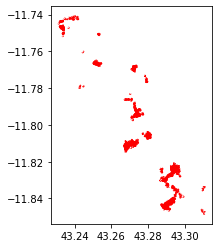

In [7]:
buildings_gdf.plot(edgecolor='red', linewidth=2);

In [8]:
buildings_gdf.columns

Index(['nodes', 'geometry', 'building', 'name', 'amenity', 'denomination',
       'religion', 'source', 'source_1', 'building:levels', 'area', 'length',
       'building:condition', 'building:material', 'comoros-dgsc:code',
       'roof:material', 'source:geometry', 'office', 'height', 'addr:city',
       'shop', 'addr:street'],
      dtype='object')

In [9]:
buildings_gdf.head()

,nodes,geometry,building,name,amenity,denomination,religion,source,source_1,building:levels,...,building:condition,building:material,comoros-dgsc:code,roof:material,source:geometry,office,height,addr:city,shop,addr:street
369069459,"[3728944964, 3728944967, 3728944936, 372894495...","POLYGON ((43.2794523 -11.80665, 43.2795914 -11...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369069461,"[3728944944, 3728944958, 3728944961, 372894495...","POLYGON ((43.2794037 -11.806205, 43.2794912 -1...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369069462,"[3728944954, 3728944966, 3728944946, 372894495...","POLYGON ((43.2796457 -11.8069795, 43.2797118 -...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369069463,"[3728944948, 3728944938, 3728944965, 372894496...","POLYGON ((43.2790613 -11.8066263, 43.2791229 -...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369069465,"[3728944942, 3728944962, 3728944963, 372894496...","POLYGON ((43.2791949 -11.8069023, 43.2792905 -...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explore the distributions of distinct values for some attributes

In [10]:
buildings_gdf['building'].value_counts()

yes            1316
residential     668
apartments       18
commercial       17
mosque            9
industrial        8
public            6
school            3
house             1
Name: building, dtype: int64

In [11]:
buildings_gdf['amenity'].value_counts()

place_of_worship    16
community_centre     7
marketplace          4
school               4
restaurant           1
library              1
Name: amenity, dtype: int64

In [12]:
buildings_gdf['source'].value_counts()

#opendri-comoros;survey                 752
#osm4km                                 563
#opendri-comoros                        190
#opendri-comoros; DGSC; initial load     22
DGCS-Comoros                              6
Kaart Ground Survey 2017                  5
Name: source, dtype: int64

### ... and the distribution of building footprint area

We'll reproject to [UTM](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) in order to calculate building footprint polygon areas in $m^2$. First we need to identify EPSG code for the UTM Zone our lat-lon bounding box is in. For reference, we'll use use the `from_latlon` function from the [utm package](https://github.com/Turbo87/utm) to get the UTM Zone code. But we'll generate the EPSG code directly using a simple equation I found, using the latitude and longitude of the center of the bounding box. I found this equation (and related discussions) by Googling and landing on the [GIS StackExchange](https://gis.stackexchange.com): see [here](https://gis.stackexchange.com/questions/190198/how-to-get-appropriate-crs-for-a-position-specified-in-lat-lon-coordinates) and [here](https://gis.stackexchange.com/questions/269518/auto-select-suitable-utm-zone-based-on-grid-intersection).

In [13]:
utmzone_code = utm.from_latlon(bbox_ctr[0], bbox_ctr[1])[-2:]
utmzone_epsg = 32700 - round((45+bbox_ctr[0])/90)*100 + round((183+bbox_ctr[1])/6)
utmzone_code, utmzone_epsg

((38, 'L'), 32738)

In [14]:
buildings_gdf_utm = buildings_gdf.to_crs(epsg=utmzone_epsg)

In [15]:
building_area_m2 = buildings_gdf_utm.geometry.area

Print out simple stats, then plot a slightly customized historgram.

In [16]:
building_area_m2.min(), building_area_m2.mean(), building_area_m2.median(), building_area_m2.max()

(1.4053317558159584, 132.18867198942908, 78.8650210469506, 2083.277673061675)

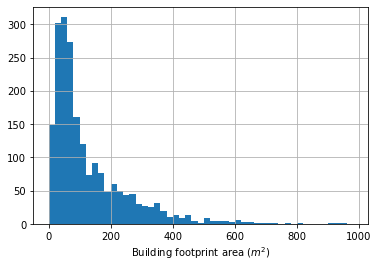

In [17]:
bins_seq = [i for i in range(0, 1000, 20)]
buildings_gdf_utm.geometry.area.hist(bins=bins_seq);
plt.xlabel('Building footprint area ($m^2$)');

## 5. Extract waterways from OSM on the same bounding box, using OSMnx `graph_from_bbox`

We'll use `graph_from_bbox` to request the "network graph" (*edges* and *nodes*, in graph speak), then convert the graph edges (lines) to a Linestring GeoDataFrame using OSMnx `graph_to_gdfs`. Note the arguments `network_type='none'` and `infrastructure` followed by string that starts with `way`. "infrastructure" is a generic label derived maybe too directly from the OSM focus on the built environment (roads, buildings, etc), but it's used in `OSMnx` to request any type of feature. We're using the `Other infrastructure` feature in OSMnx, illustrated at [this osmnx example notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/16-work-with-other-infrastructures.ipynb).

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Navigating and finding OSM tag types</b></br>

OSM ["represents physical features on the ground (e.g., roads or buildings) using tags attached to its basic data structures (its nodes, ways, and relations)"](https://wiki.openstreetmap.org/wiki/Map_Features). OSM tags can be messy (if you ask me) and hard to navigate. Go to https://wiki.openstreetmap.org/wiki/Map_Features to navigate the (overlapping) hierarchies of tags. "Waterways" are found as multiple tag types; the most useful ones I found are "Waterway" and "Natural". You can learn more about the variety of waterway tags here:
- https://wiki.openstreetmap.org/wiki/Waterways
- https://wiki.openstreetmap.org/wiki/Map_Features#Waterway
- https://wiki.openstreetmap.org/wiki/Map_Features#Water_related
- https://stackoverflow.com/questions/55033816/plotting-importing-rivers-in-osmnx

The OSM [Nominatim API](https://nominatim.org) may be of interest, too: "Nominatim (from the Latin, 'by name') is a tool to search OSM data by name and address and to generate synthetic addresses of OSM points (reverse geocoding)."

</div>

### Read `waterway` ways

In [18]:
waterways_g = ox.graph_from_bbox(north=north, south=south, east=east, west=west,
                                 network_type='none', infrastructure='way["waterway"]',
                                 retain_all=True, truncate_by_edge=True, simplify=False)

In [19]:
waterways_edges_gdf = ox.graph_to_gdfs(waterways_g, nodes=False)
len(waterways_edges_gdf)

926

In [20]:
waterways_edges_gdf.head()

,u,v,key,osmid,name,oneway,length,geometry
0,1019314269,1019932392,0,87706692,Pessini,False,110.747,"LINESTRING (43.2640864 -11.8010712, 43.2650795..."
1,1019932245,1019932388,0,87706693,NaN,False,47.895,"LINESTRING (43.2760658 -11.7987359, 43.2756259..."
2,1019932245,1019932287,0,87706693,NaN,False,88.895,"LINESTRING (43.2760658 -11.7987359, 43.2768705..."
3,1019932250,1019932358,0,87706692,Pessini,False,35.509,"LINESTRING (43.2742955 -11.8005633, 43.2739737..."
4,1019932250,1019932309,0,87706692,Pessini,False,28.244,"LINESTRING (43.2742955 -11.8005633, 43.2744243..."


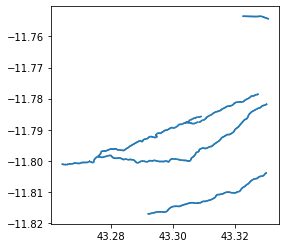

In [21]:
waterways_edges_gdf.plot();

### Read `natural:water` ways
The request is identical to the previous one, except for `infrastructure='way["natural"~"water"]'`

In [22]:
natwater_g = ox.graph_from_bbox(north=north, south=south, east=east, west=west,
                                network_type='none', infrastructure='way["natural"~"water"]',
                                retain_all=True, truncate_by_edge=True, simplify=False)

natwater_edges_gdf = ox.graph_to_gdfs(natwater_g, nodes=False)
len(natwater_edges_gdf)

56

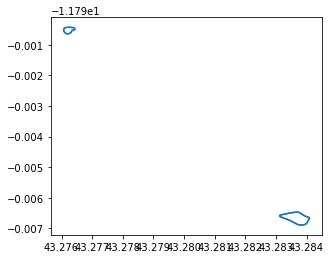

In [23]:
natwater_edges_gdf.plot();

## 6. Let's put it all together: All OSM-derived layers on a single plot

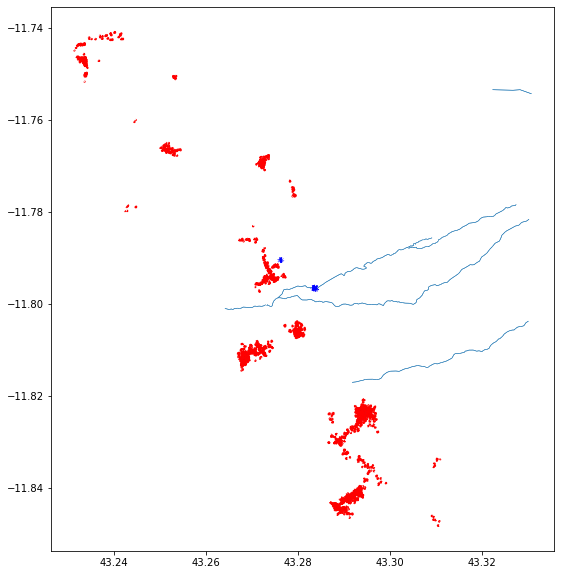

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
waterways_edges_gdf.plot(ax=ax, linewidth=0.5)
natwater_edges_gdf.plot(ax=ax, edgecolor='blue', linewidth=5)
buildings_gdf.plot(ax=ax, edgecolor='red', linewidth=2);

**NOW DO THIS WITH HOLOVIEWS AND HVPLOT, WITH AN OSM TILE SOURCE!**